# AUC

## Objectives

1. Calculate AUDPC (area under the disease progress curve) for each panel at each time point (downy mildew only) using the full scout record.

2. Calculate correlation between AUDPC and vegetation indices (VIs) at image timepoints. Compare to severity vs. VI correlations.

## 1. AUDPC, full scout record

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from scipy import integrate
from matplotlib import pyplot as plt


In [2]:
# read in scout data for each year separately

scout_2020 = pd.read_csv('../data/scout/scout_2020_gdf.csv')
scout_2021 = pd.read_csv('../data/scout/scout_2021_gdf.csv')
scout_2022 = pd.read_csv('../data/scout/scout_2022_gdf.csv')

In [3]:
scout_2020.head()

,Date,Row,Panel,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid
0,2020-06-18,1,1,5.0,PM,0.0,0.00,0.00,POLYGON ((-77.0152645742787 42.878300949250196...,POINT (-77.0153084903025 42.8783140936145)
1,2020-06-18,1,2,9.0,PM,0.0,0.05,5.05,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654)
2,2020-06-18,1,4,18.0,PM,0.0,0.00,0.50,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055)
3,2020-06-18,1,5,6.0,PM,0.0,0.00,15.10,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546)
4,2020-06-18,1,6,2.0,PM,0.0,0.00,5.65,"POLYGON ((-77.01570014425 42.878381989255075, ...",POINT (-77.01574402030295 42.87839504362453)


In [4]:
# Functionalize

def add_audpc(df, date_col, dis_col):
    
    '''Inputs:
    df (pandas dataframe) - dataframe with dates and disease ratings
    date_col (str) - name of the column containing dates
    dis_col (str) - name of the column containing disease ratings
    '''
    
    #Calculate AUDPC for each date
    x_vals = df[date_col]
    
    y_vals = df[dis_col]
    
    # for more on trapezoidal integration, 
    # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html
    
    integrals = integrate.cumulative_trapezoid(y_vals, x_vals, initial=0)
    
    #Add audpc column to original dataframe
    df['audpc'] = integrals
    
    #return df

Problem: Calculating AUC with only the above function groups all panels together on each day.
Solution: Group entries by panel geometry and find AUDPC for each panel separately.

In [5]:
# Re-functionalize

def panel_audpc(df, date_col, dis_col):
    
    #Convert date from str to datetime
    as_datetime = pd.to_datetime(df[date_col], infer_datetime_format=True)
    
    #Convert dates to DOY
    day_of_year = np.asarray([d.timetuple().tm_yday for d in as_datetime])
    
    # Subtract first date from all dates to scale the AUDPC calculation
    scaled = np.asarray([d-day_of_year.min() for d in day_of_year])
    
    # Add column for DOY
    df['doy'] = scaled
    
    #group by geometry 
    geometries = df.geometry.unique()
    panel_dfs=[]
    
    for g in geometries:
        panel_df = df[df['geometry']==g]
        panel_dfs.append(panel_df)
    
    for p in panel_dfs:
        add_audpc(p, 'doy', dis_col)
    
    #recombine the dataframes
    
    recomb = pd.concat(panel_dfs).sort_values(by=['Date', 'Row', 'Panel'])
    
    return recomb

In [6]:
audpc_2020 = panel_audpc(scout_2020, 'Date', 'DM_severity')
audpc_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 0 to 1171
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1172 non-null   object 
 1   Row          1172 non-null   int64  
 2   Panel        1172 non-null   int64  
 3   Treatment    1172 non-null   float64
 4   Block        1172 non-null   object 
 5   PM_severity  1172 non-null   float64
 6   DM_severity  1172 non-null   float64
 7   total_dis    1172 non-null   float64
 8   geometry     1172 non-null   object 
 9   centroid     1172 non-null   object 
 10  audpc        1172 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 109.9+ KB


/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [7]:
audpc_2021 = panel_audpc(scout_2021, 'Date', 'DM_severity')
audpc_2021.info()

/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 0 to 1919
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1920 non-null   object 
 1   Row          1920 non-null   int64  
 2   Panel        1920 non-null   int64  
 3   Treatment    1920 non-null   float64
 4   Block        1920 non-null   object 
 5   PM_severity  1919 non-null   float64
 6   DM_severity  1915 non-null   float64
 7   total_dis    1920 non-null   float64
 8   geometry     1920 non-null   object 
 9   centroid     1920 non-null   object 
 10  audpc        1913 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 180.0+ KB


In [8]:
audpc_2021.head()

,Date,Row,Panel,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid,audpc
0,2021-06-24,1,1,5.0,DM,0.0,0.0,0.10,POLYGON ((-77.0152645742787 42.878300949250196...,POINT (-77.0153084903025 42.8783140936145),0.0
1,2021-06-24,1,2,7.0,DM,0.0,0.0,0.20,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654),0.0
2,2021-06-24,1,3,9.0,DM,0.0,0.0,0.15,POLYGON ((-77.01544069426711 42.87833411925217...,POINT (-77.01548247530272 42.87834674861851),0.0
3,2021-06-24,1,4,15.0,DM,0.0,0.0,0.15,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055),0.0
4,2021-06-24,1,5,3.0,DM,0.0,0.0,0.15,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546),0.0


In [9]:
audpc_2022 = panel_audpc(scout_2022, 'Date', 'DM_severity')
audpc_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1871 entries, 0 to 1870
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1871 non-null   object 
 1   Row          1871 non-null   int64  
 2   Panel        1871 non-null   int64  
 3   Treatment    1871 non-null   int64  
 4   Block        1871 non-null   object 
 5   PM_severity  1679 non-null   float64
 6   DM_severity  1871 non-null   float64
 7   total_dis    1679 non-null   float64
 8   geometry     1871 non-null   object 
 9   centroid     1871 non-null   object 
 10  audpc        1871 non-null   float64
dtypes: float64(4), int64(3), object(4)
memory usage: 175.4+ KB


/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3998/3049353897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

<function matplotlib.pyplot.show(close=None, block=None)>

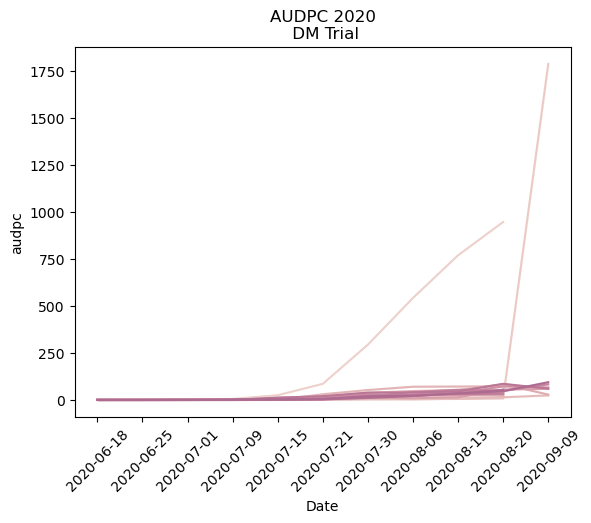

In [18]:
#Plot the DM trial treatments for 2020

data = audpc_2020[audpc_2020['Block']=='DM']

sns.lineplot(data=data, x='Date', y='audpc', hue='Treatment', legend=False, errorbar=('ci', False))
plt.xticks(rotation=45)
plt.title('AUDPC 2020\n DM Trial')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

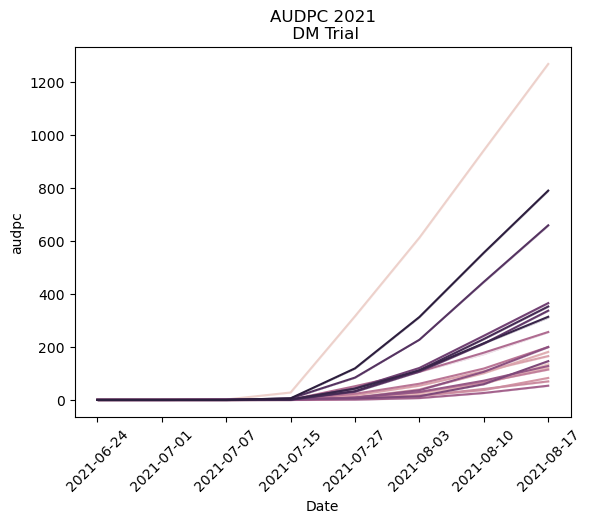

In [17]:
#Plot the DM trial treatments for 2021

data_2021 = audpc_2021[audpc_2021['Block']=='DM']

sns.lineplot(data=data_2021, x='Date', y='audpc', hue='Treatment', legend=False, errorbar=('ci', False))
plt.xticks(rotation=45)
plt.title('AUDPC 2021\n DM Trial')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

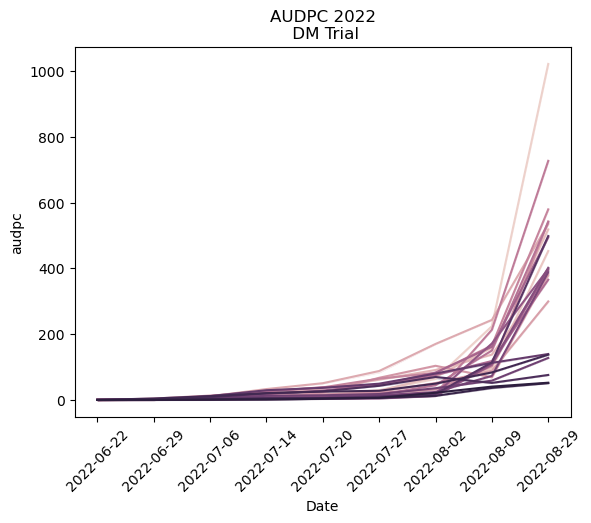

In [16]:
#Plot the DM trial treatments for 2022

data_2022 = audpc_2022[audpc_2022['Block']=='DM']

sns.lineplot(data=data_2022, x='Date', y='audpc', hue='Treatment', legend=False, errorbar=('ci', False))
plt.xticks(rotation=45)
plt.title('AUDPC 2022\n DM Trial')
plt.show

Text(0.5, 1.0, 'AUDPC 2022')

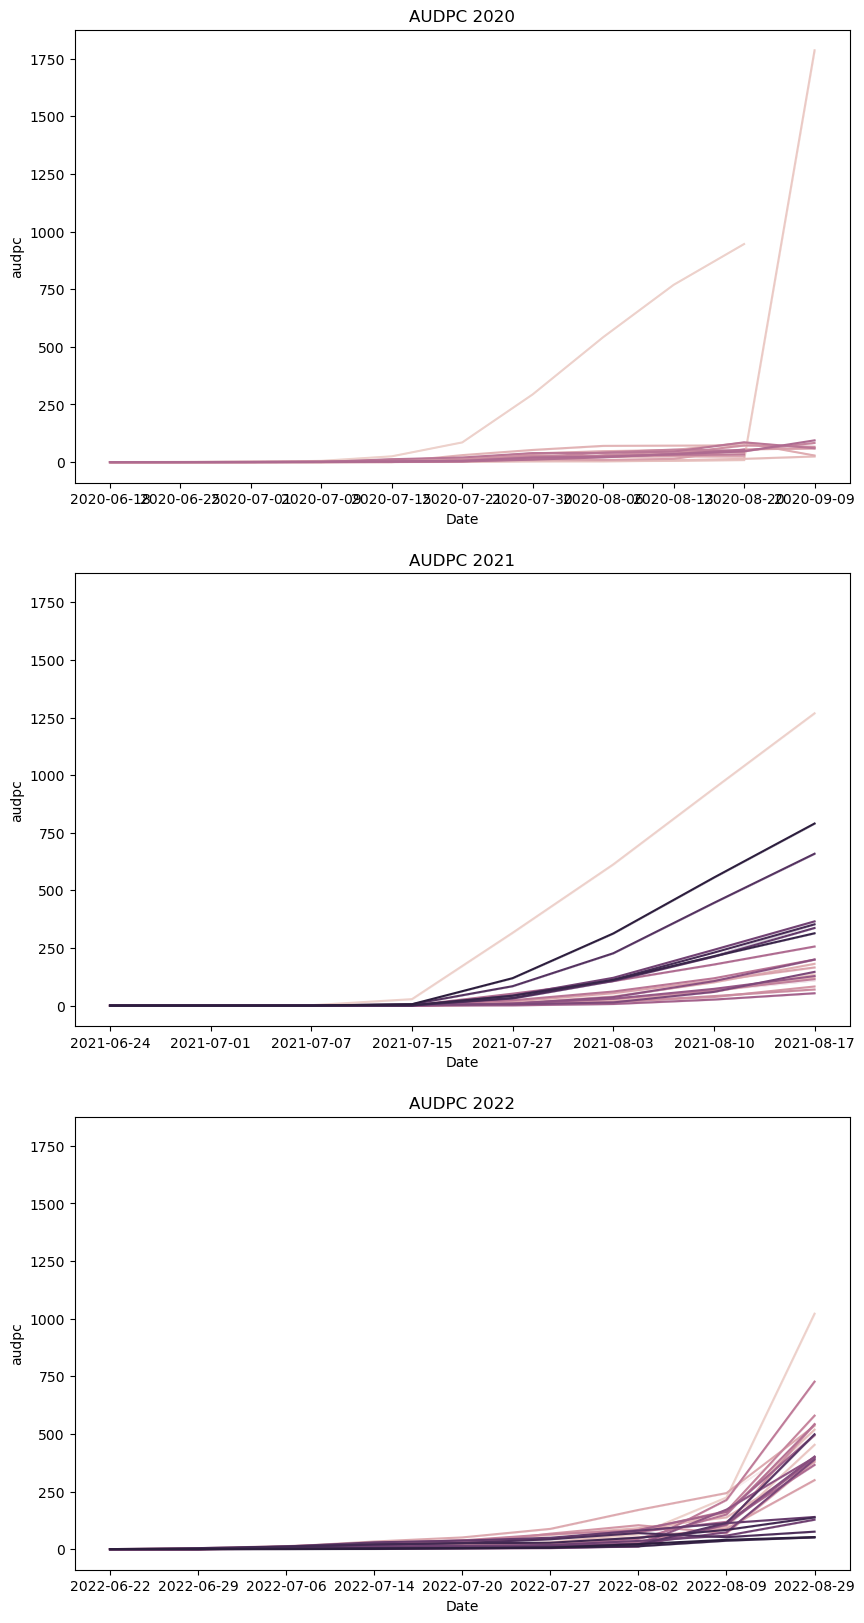

In [45]:
fig, axes = plt.subplots(3, 1, sharey=True,figsize=(10,20))

sns.lineplot(ax=axes[0], data=data, x='Date', y='audpc', hue='Treatment', legend=False, errorbar=('ci', False))
axes[0].set_title('AUDPC 2020')

sns.lineplot(ax=axes[1], data=data_2021, x='Date', y='audpc', hue='Treatment', legend=False, errorbar=('ci', False))
axes[1].set_title('AUDPC 2021')

sns.lineplot(ax=axes[2], data=data_2022, x='Date', y='audpc', hue='Treatment', legend=False, errorbar=('ci', False))
axes[2].set_title('AUDPC 2022')

# 2. Correlation w VIs

In [81]:
# Read in img_scout dfs

img_scout_2020 = pd.read_csv('../data/img_scout_dfs/2020/skysat_scout_2020.csv')
img_scout_2021 = pd.read_csv('../data/img_scout_dfs/2021/skysat_scout_2021.csv')
img_scout_2022 = pd.read_csv('../data/img_scout_dfs/2022/skysat_scout_2022.csv')
img_scout_2020.head()

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid
0,20200625,2,0.055840,0.074537,0.063650,0.284137,1,2,2020-06-25,9.0,PM,0.0,0.0,0.15,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654)
1,20200625,3,0.051873,0.070787,0.058603,0.277567,1,3,2020-06-25,22.0,PM,0.0,0.0,0.10,POLYGON ((-77.01544069426711 42.87833411925217...,POINT (-77.01548247530272 42.87834674861851)
2,20200625,4,0.052025,0.073668,0.061257,0.285911,1,4,2020-06-25,18.0,PM,0.0,0.0,0.40,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055)
3,20200625,5,0.047086,0.067566,0.049576,0.312017,1,5,2020-06-25,6.0,PM,0.0,0.0,0.35,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546)
4,20200625,6,0.051490,0.073420,0.058720,0.301683,1,6,2020-06-25,2.0,PM,0.0,0.0,0.00,"POLYGON ((-77.01570014425 42.878381989255075, ...",POINT (-77.01574402030295 42.87839504362453)


In [82]:
merged_2020 = pd.merge(img_scout_2020, audpc_2020)
merged_2021 = pd.merge(img_scout_2021, audpc_2021)
merged_2022 = pd.merge(img_scout_2022, audpc_2022)


In [85]:
merged_2022.head()

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid,Row,Panel,audpc
0,20220622,1,0.058377,0.084667,0.086377,0.367607,1,1,2022-06-22,26.0,PM,0.0,0.0,0.75,POLYGON ((-77.0152645742787 42.878300949250196...,POINT (-77.0153084903025 42.8783140936145),1,1,0.0
1,20220622,2,0.058603,0.085176,0.088338,0.357583,1,2,2022-06-22,17.0,PM,0.0,0.0,1.05,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654),1,2,0.0
2,20220622,3,0.059032,0.086039,0.087004,0.360371,1,3,2022-06-22,31.0,PM,0.0,0.0,0.50,POLYGON ((-77.01544069426711 42.87833411925217...,POINT (-77.01548247530272 42.87834674861851),1,3,0.0
3,20220622,4,0.057917,0.086170,0.088193,0.365127,1,4,2022-06-22,3.0,PM,0.0,0.0,0.95,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055),1,4,0.0
4,20220622,5,0.059172,0.085890,0.089700,0.359786,1,5,2022-06-22,27.0,PM,0.0,0.0,0.80,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546),1,5,0.0


In [77]:
def add_vis(df):
    df['ndvi']= (df['nir']-df['red'])/(df['nir']+df['red'])
    df['evi']= 2.5*(df['nir']-df['red'])/(df['nir']+6*df['red']-7.5*df['blue']+1)
    df['savi']= 1.5*(df['nir']-df['red'])/(df['nir']+df['red']+0.5)
    df['sr']= df['nir']/df['red']
    df['msr']= ((df['nir']/df['red'])-1)/(np.sqrt((df['nir']/df['red'])+1))
    #df['dvi']= df['nir']-df['red']
    #df['nirv']= df['ndvi']*df['nir']
    df['gcc']=df['green']/(df['green']+df['red']+df['blue'])
    #df['tvi']=0.5*(120*(df['nir']-df['green'])-200*(df['red']-df['green']))
    df['arvi']=(df['nir']-(2*df['red']-df['blue']))/(df['nir']+(2*df['red']-df['blue']))
    
    return df

In [86]:
vis_2020 = add_vis(merged_2020)
vis_2021 = add_vis(merged_2021)
vis_2022 = add_vis(merged_2022)

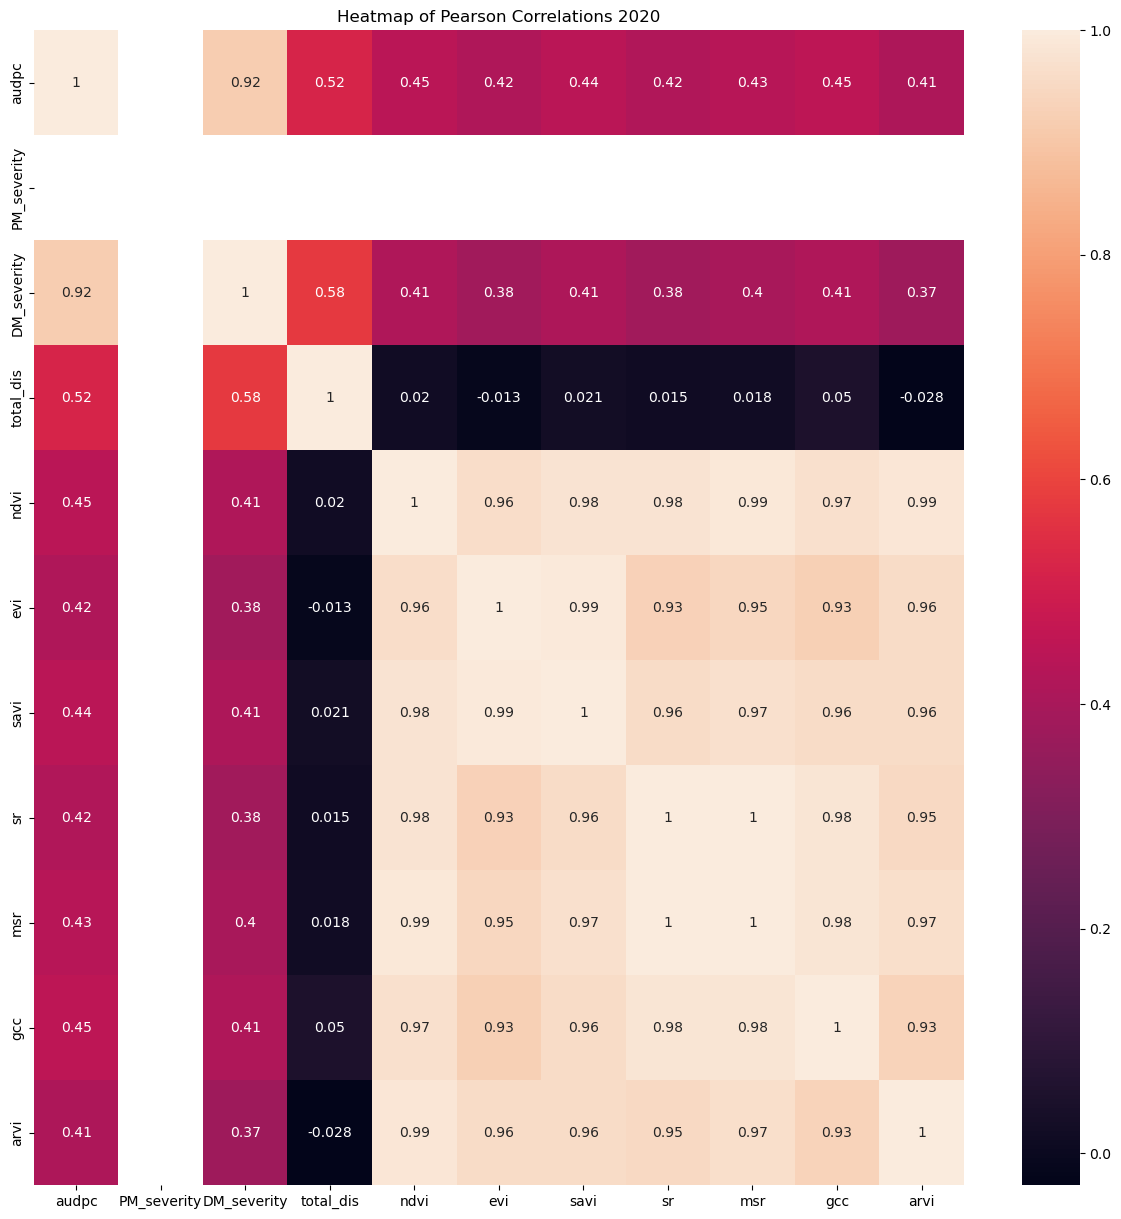

In [80]:
cols = ['audpc','PM_severity','DM_severity', 'total_dis', 'ndvi', 'evi', 'savi', 'sr', 'msr', 'gcc', 'arvi']
filtered = vis_2020[cols]
correlations = filtered.corr()

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlations, annot=True).set(title='Heatmap of Pearson Correlations 2020');
plt.show()

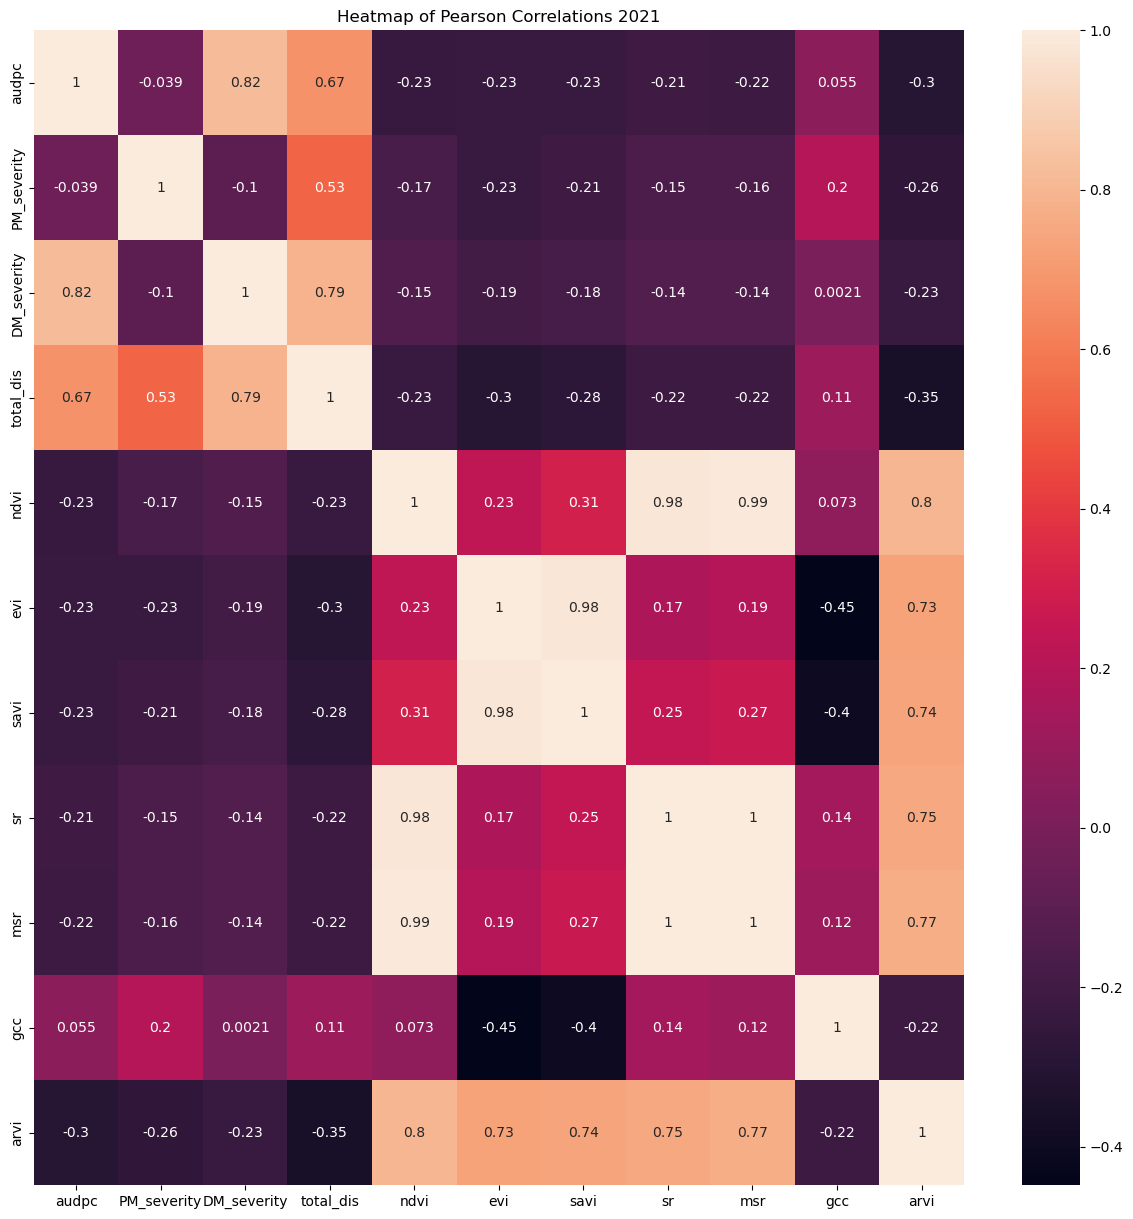

In [87]:
filtered_2021 = vis_2021[cols]
correlations_2021 = filtered_2021.corr()

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlations_2021, annot=True).set(title='Heatmap of Pearson Correlations 2021');
plt.show()

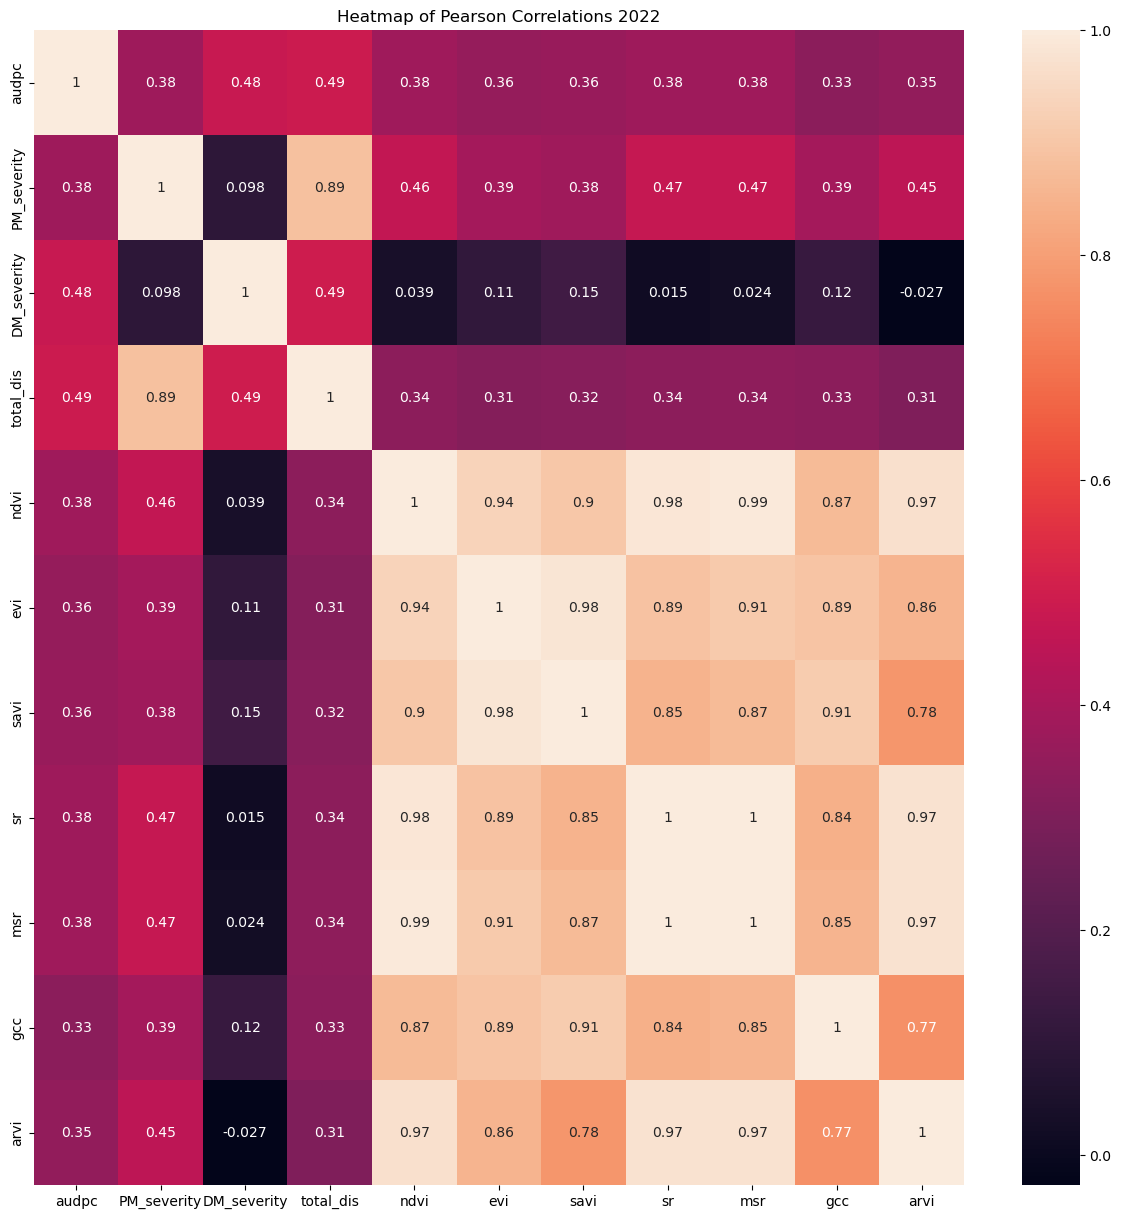

In [88]:
filtered_2022 = vis_2022[cols]
correlations_2022 = filtered_2022.corr()

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlations_2022, annot=True).set(title='Heatmap of Pearson Correlations 2022');
plt.show()